# 2.7

In [106]:
import ugradio
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import glob
import astropy
import time
import astropy.units as u

In [38]:
def PS(x, divisor):
    """Takes in a complex array and outputs a plot of frequency versus power spectrum."""

    Vsamp = 62.5/divisor
    N = 16000
    
    a = x[:len(x)/2]
    b = x[len(x)/2:]
    c = a + b * 1j

    time = np.linspace(-N/(2*Vsamp),(N/2-1)/Vsamp,N)
    
    f,fx = ugradio.dft.dft(c[:N],t=time, vsamp=Vsamp)
    P = np.abs(fx)**2
    plt.plot(f,P)
    plt.xlabel("Frequency")
    plt.ylabel("Power [volt-second^2]")
    plt.show()

## Average

### Changing First LO

LO for upper baseband: 1231 MHz

LO for lower baseband: 1229 MHz

Power of LO: 13 dBm

x = ugradio.pico.capture_data('50mV', divisor=8, dual_mode=True, nsamples=16000, nblocks=1000)

np.save('upper_block_n', x)

Took data 10 times resulting in 10,000 total blocks. Repeated for lower.

In [86]:
def avg_ps(data, n=1000):
    """Takes in a dualmode dataset of n blocks -- 16000 samples each -- and returns a power spectrum averaged over all blocks.
    
    Parameters
    ----------
    data : data taken from pico sampler, loaded as an array
    n : number of blocks of data taken

    Returns
    -------
    avg_power : average power spectrum of n blocks of complex data"""
    
    real = data[:len(data)/2]
    imag = data[len(data)/2:len(data)]
    complex_data = real + (imag * 1j)
   
    power_blocks = [] # total len = n, item len = 16000

    for i in range(n):
        x = complex_data[i * 16000 : 16000 * (i + 1)]
        voltage = np.fft.fft(x)
        power = np.abs(voltage)**2
        power_blocks.append(power)
         
    avg_power = sum(power_blocks) / len(power_blocks)
    return(avg_power)

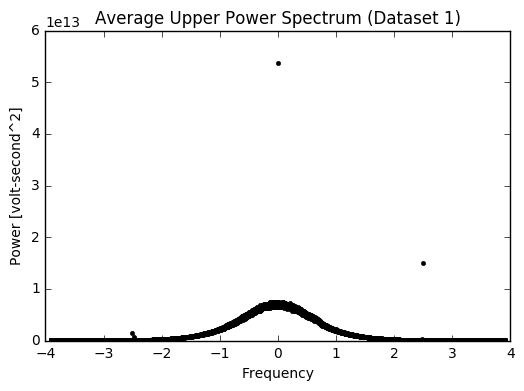

In [56]:
data = np.load('upper_block_1.npy')
power = avg_ps(data, 1000)
freq = np.fft.fftfreq(len(power), 1/(62.5/8))
plt.plot(freq, power, 'k.')
plt.title('Average Upper Power Spectrum (Dataset 1)')
plt.xlabel('Frequency')
plt.ylabel('Power [volt-second^2]')
plt.show()

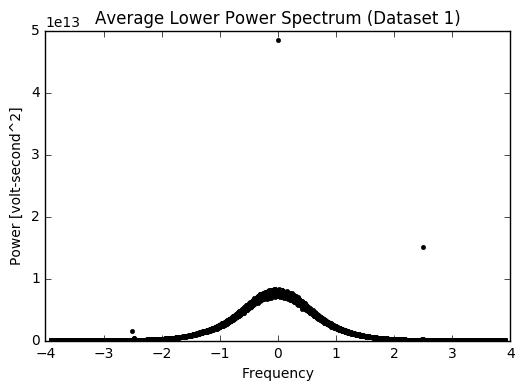

In [59]:
data = np.load('lower_block_1.npy')
power = avg_ps(data, 1000)
freq = np.fft.fftfreq(len(power), 1/(62.5/8))
plt.plot(freq, power, 'k.')
plt.title('Average Lower Power Spectrum (Dataset 1)')
plt.xlabel('Frequency')
plt.ylabel('Power [volt-second^2]')
plt.show()

In [60]:
upper = [avg_ps(np.load(f), 1000) for f in glob.glob('upper_block_*.npy')]

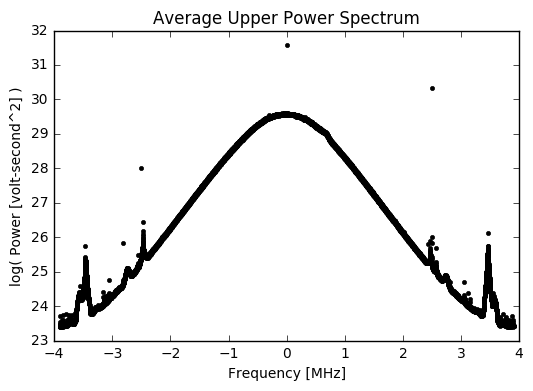

In [61]:
avg_upper = sum(upper) / len(upper)
frequency = np.fft.fftfreq(len(avg_upper), 1/(62.5/8))

plt.plot(frequency, np.log(avg_upper), 'k.')
plt.title('Average Upper Power Spectrum')
plt.xlabel('Frequency [MHz]')
plt.ylabel('log( Power [volt-second^2] )')
plt.show()

In [62]:
lower = [avg_ps(np.load(f),1000) for f in glob.glob('lower_block_*.npy')]

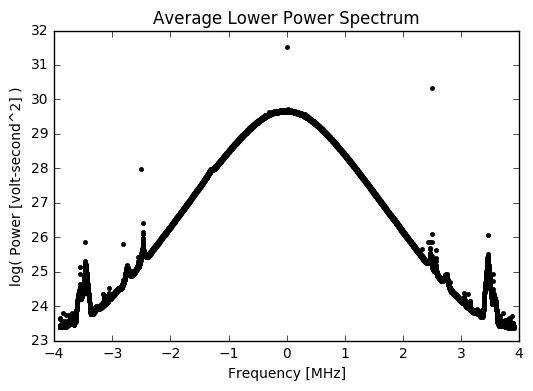

In [64]:
avg_lower = sum(lower) / len(lower)
frequency = np.fft.fftfreq(len(avg_lower), 1/(62.5/8))

plt.plot(frequency, np.log(avg_lower), 'k.')
plt.title('Average Lower Power Spectrum')
plt.xlabel('Frequency [MHz]')
plt.ylabel('log( Power [volt-second^2] )')
plt.show()

## Line Shape

In [65]:
s_on = avg_upper
s_off = avg_lower

s_line = s_on/s_off

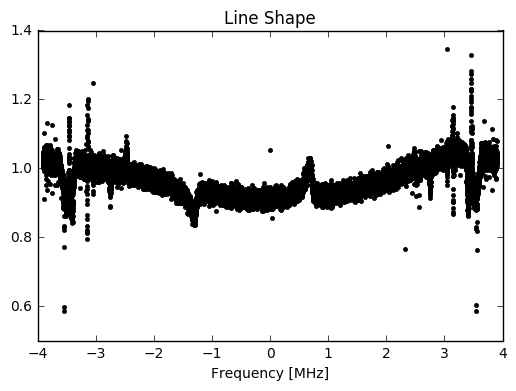

In [66]:
frequency = np.fft.fftfreq(len(s_line), 1/(62.5/8))
plt.plot(frequency, s_line, 'k.')
plt.title('Line Shape')
plt.xlabel('Frequency [MHz]')
plt.show()

## Line Intensity

In [46]:
T_cold = 3 # K
T_cal = 300 # K

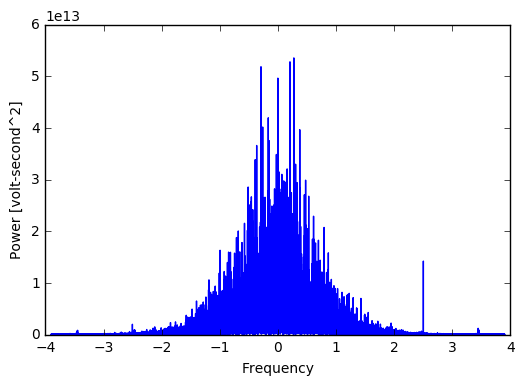

In [48]:
cold = np.loadtxt('sCold-2-24-19.txt')
PS(cold, 8)
plt.title('Sky pspec')

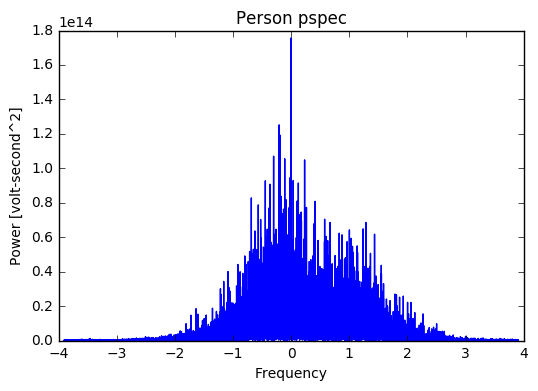

In [45]:
cal = np.loadtxt('sPerson-2-24-19.txt')
PS(cal, 8)
plt.title('Person pspec')

In [43]:
Vsamp = 62.5/8
N = 16000
time = np.linspace(-N/(2*Vsamp),(N/2-1)/Vsamp,N)

cold = np.loadtxt('sCold-2-24-19.txt')
a_cold = cold[:len(cold)/2]
b_cold = cold[len(cold)/2:]
c_cold = a_cold + b_cold * 1j
f,fx = ugradio.dft.dft(c_cold[:N],t=time, vsamp=Vsamp)
P_cold = np.abs(fx)**2

cal = np.loadtxt('sPerson-2-24-19.txt')
a_cal = cal[:len(cal)/2]
b_cal = cal[len(cal)/2:]
c_cal = a_cal + b_cal * 1j
f,fx = ugradio.dft.dft(c_cal[:N],t=time, vsamp=Vsamp)
P_cal = np.abs(fx)**2

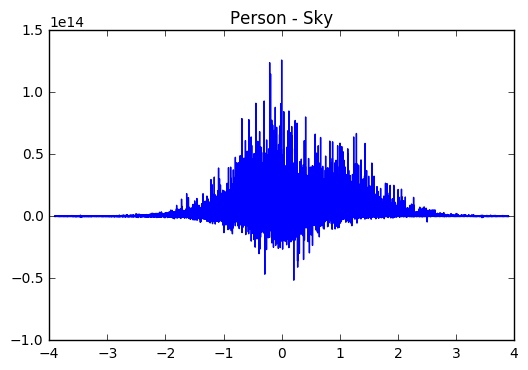

In [39]:
plt.plot(f, P_cal-P_cold)
plt.title('Person - Sky')
plt.show()

In [40]:
# obtain gain

G = (T_cal - T_cold)/(np.sum(P_cal - P_cold)) * np.sum(P_cold)
print(G)

126.34495924


In [67]:
T_line = s_line * G

## Plot Intensity vs. Frequency

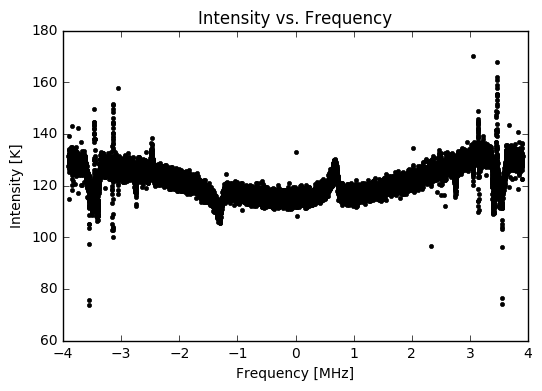

In [68]:
frequency = np.fft.fftfreq(len(T_line), 1/(62.5/8))
plt.plot(frequency, T_line, 'k.')
plt.title('Intensity vs. Frequency')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity [K]')
plt.show()

## Doppler Correction

In [ ]:
ugradio.doppler.get_projected_velocity(ra, dec, jd, obs_lat=37.873199, obs_lon=-122.257063, obs_alt=120.0, epoch=2451545.0)

get_projected_velocity(ra, dec, jd, obs_lat=nch.lat, obs_lon=nch.lon, 
        obs_alt=nch.alt, epoch=2451545.):
    '''Compute the projected velocity of the telescope wrt the 
    Local Standard of Rest.
    Parameters
    ----------
    ra, dec : float degrees, the RA/DEC of target
    jd      : float, julian date (UTC) of the observation
    obs_lat : float degrees, latitude of observatory, default=nch.lat
    obs_lon : float degrees, longitude of observatory, default=nch.lon
    obs_alt : float meters, altitude of observatory, default=nch.alt
    epoch   : float, julian date epoch of ra/dec coordinates
              default=2451545 is J2000

    Returns
    -------
    v : float m/s, barycenter-corrected radial velocity,
        see (Wright & Eastman, 2014) '''

In [43]:
# data taken changing first LO

lat = 37.873199 # for Campbell Hall

jd = 2458539.451389 # 22:50 UTC (14:50 PST), 2/24/2019
lst = ugradio.timing.lst(jd)

v = ugradio.doppler.get_projected_velocity(ra=lst, dec=lat, jd=jd) 
print(v)

[-16861.65812534]


data taken changing second LO

lat = 37.873199 # for Campbell Hall

jd = ugradio.timing.julian_date() # 20:42 UTC (12:42 PST), 2/27/2019
lst = ugradio.timing.lst()

v = ugradio.doppler.get_projected_velocity(ra=lst, dec=lat, jd=jd) 
print(v)

In [47]:
# frequency offset

c = 299792.458 #km/s
f_0 = 1420.4058 # MHz
f = -f_0 * (v / c)
print(f)

[ 79.88992505]


<IPython.core.display.Javascript object>


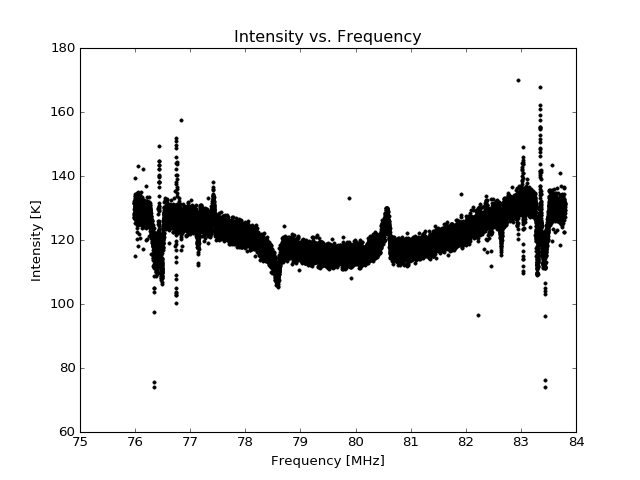

In [50]:
frequency = np.fft.fftfreq(len(T_line), 1/(62.5/8))
plt.plot(frequency + f, T_line, 'k.')
plt.title('Intensity vs. Frequency')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity [K]')
plt.show()

# 2.8

lat = 37.873199 # for Campbell Hall
lat_rad = np.radians(lat)

jd = ugradio.timing.julian_date()
lst = ugradio.timing.lst(jd)

rot_ge = [[-0.054876, 0.494109, -0.867666],
          [-0.873437, 0.444830, -0.198076],
          [-0.483835, 0.746982, 0.455984]]

rot_eh = [[-np.sin(lat_rad), 0, np.cos(lat_rad)],
          [0, -1, 0],
          [np.cos(lat_rad), 0, np.sin(lat_rad)]]

rot_ha = [[np.cos(lst), np.sin(lst), 0],
          [np.sin(lst), -np.cos(lst), 0],
          [0, 0, 1]]

rot_ga = np.dot(rot_ha, np.dot(rot_eh, rot_ge))

long, latg = 120, 0

x = [np.cos(latg) * np.cos(long), np.cos(latg) * np.sin(long), np.sin(latg)]

eq_coords = np.dot(rot_ge, x)

print(eq_coords)

def get_altaz(ra, dec, jd=None, lat=37.8732, lon=-122.2573, alt=200, equinox='J2000'):
    """
    Return the altitude and azimuth of an object whose right ascension 
    and declination are known.
    Parameters
    ----------
    ra : float, right ascension in degrees
    dec: float, declination in degrees
    jd : float, Julian Date, default=now
    lat: float, latitude in degrees, default=nch
    lon: float, longitude in degrees, default=nch
    alt: float, altitude in m, default=nch
    equinox : string, equinox of ra/dec coordinates.  default='J2000'
    Returns
    -------
    alt : float, altitude in degrees
    az : float, azimuth in degrees
        
    """
    if jd: t = astropy.time.Time(jd,format='jd')
    else: t = astropy.time.Time(time.time(),format='unix')
    l = astropy.coordinates.EarthLocation(lat=lat*u.deg,
                        lon=lon*u.deg,height=alt*u.m)
    f = astropy.coordinates.AltAz(obstime=t,location=l)
    c = astropy.coordinates.SkyCoord(ra, dec, frame='fk5',unit='deg',equinox=equinox)
    altaz = c.transform_to(f)
    return altaz.alt.deg, altaz.az.deg

get_altaz(120, 0)

x = ugradio.pico.capture_data('50mV', divisor=8, dual_mode=True, nsamples=16000, nblocks=1000, host='10.32.92.95', port=1340, verbose=False)

np.save('cassie', x)

In [69]:
lat = 37.873199 # for Campbell Hall

jd =  ugradio.timing.julian_date()# 18:40 PST, 3/3/2019
lst = ugradio.timing.lst(jd)

v = ugradio.doppler.get_projected_velocity(ra=lst, dec=lat, jd=jd) 

# frequency offset

c = 299792.458 #km/s
f_0 = 1420.4058 # MHz
f = -f_0 * (v / c)
print(f)

[ 71.29677731]


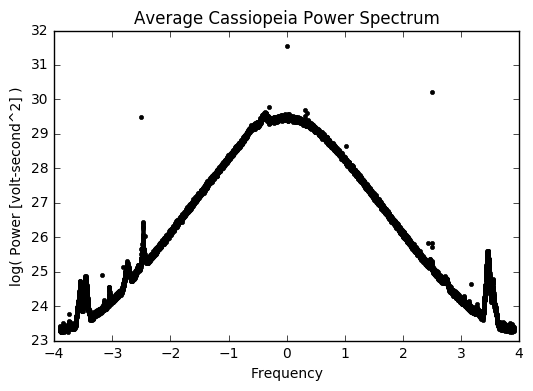

In [76]:
data = np.load('cassie.npy')

avg_power = avg_ps(data, 1000)
freq = np.fft.fftfreq(len(avg_power), 1/(62.5/8))
plt.plot(freq, np.log(avg_power), 'k.')
plt.title('Average Cassiopeia Power Spectrum')
plt.xlabel('Frequency')
plt.ylabel('log( Power [volt-second^2] )')
plt.show()

x = ugradio.pico.capture_data('50mV', divisor=8, dual_mode=True, nsamples=16000, nblocks=1000, host='10.32.92.95', port=1340, verbose=False)

np.save('cassie_upper', x)

Upper LO = 191 MHz

x = ugradio.pico.capture_data('50mV', divisor=8, dual_mode=True, nsamples=16000, nblocks=1000, host='10.32.92.95', port=1340, verbose=False)

np.save('cassie_lower', x)

Lower LO = 189 MHz

<IPython.core.display.Javascript object>


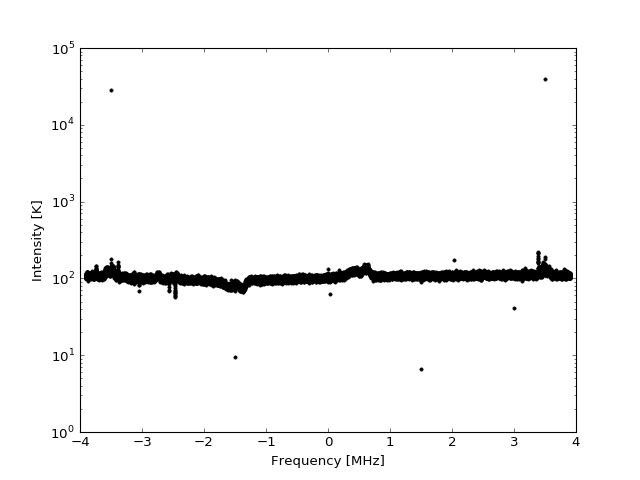

In [112]:
data_upper = np.load('cassie_upper.npy')
s_on = avg_ps(data_upper, 1000)

data_lower = np.load('cassie_lower.npy')
s_off = avg_ps(data_lower, 1000)

s_line = s_on/s_off

G = (T_cal - T_cold)/(np.sum(P_cal - P_cold)) * np.sum(P_cold)
T_line = s_line*G

frequency = np.fft.fftfreq(len(T_line), 1/(62.5/8))
plt.semilogy(frequency, T_line, 'k.')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity [K]')
plt.show()

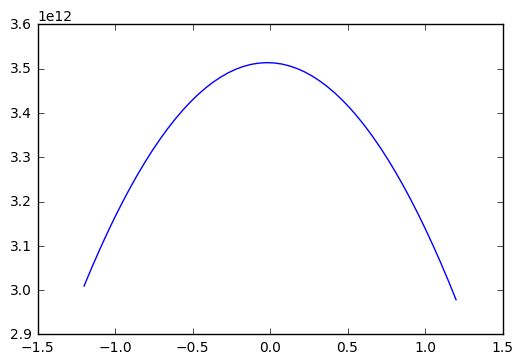

In [85]:
data = np.load('cassie_lower.npy')

avg_power = avg_ps(data, 1000)
freq = np.fft.fftfreq(len(avg_power), 1/(62.5/8))

poly = np.polyfit(freq, avg_power, 2)

x = np.linspace(-1.2, 1.2)
y = poly[0]*x**2 + poly[1]*x + poly[2]
plt.plot(x, y)

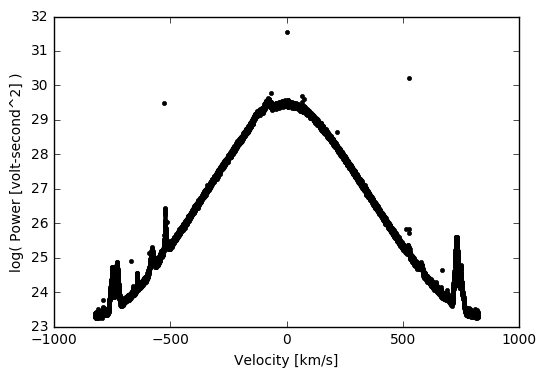

In [89]:
data = np.load('cassie.npy')

avg_power = avg_ps(data, 1000)
f = np.fft.fftfreq(len(avg_power), 1/(62.5/8))

c = 299792.458 #km/s
f_0 = 1420.4058 # MHz
v = c*f/f_0

plt.plot(v, np.log(avg_power), 'k.')
plt.title('')
plt.xlabel('Velocity [km/s]')
plt.ylabel('log( Power [volt-second^2] )')
plt.show()

In [92]:
T_cal = 300 # K

T_sys = np.sum(P_cold)/np.sum(P_cal - P_cold) * T_cal
print(T_sys)

127.62117095


In [93]:
data = np.load('cassie.npy')
P_cassie = avg_ps(data, 1000)

In [96]:
T_antHI = (P_cassie/P_cold - 1)*T_sys
print(T_antHI)

[ 1119630.23165945   110684.90578933    68564.29561895 ...,
   116291.40156981    63465.4731462    248130.81249475]


<IPython.core.display.Javascript object>


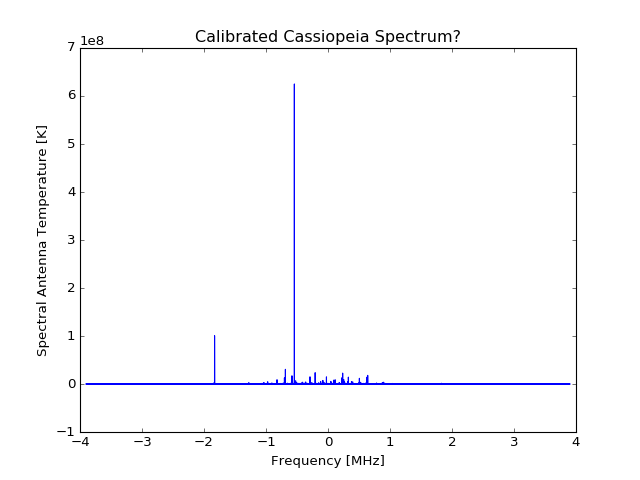

In [109]:
freq = np.fft.fftfreq(len(P_cassie), 1/(62.5/8))
plt.plot(freq, T_antHI)
plt.title('Calibrated Cassiopeia Spectrum?')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Spectral Antenna Temperature [K]')
plt.show()

<IPython.core.display.Javascript object>


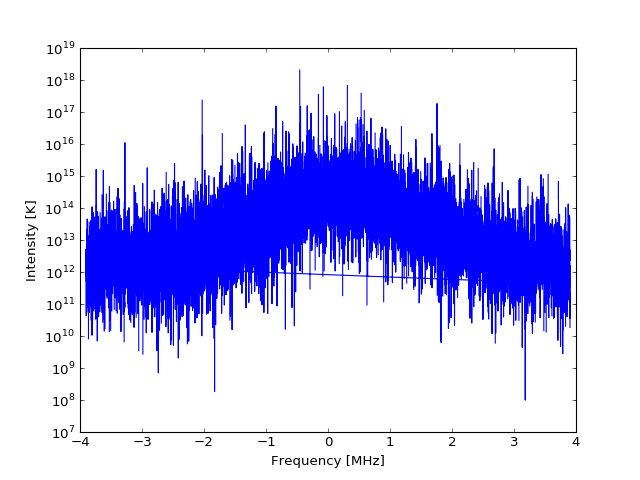

In [117]:
G = (T_cal - T_cold)/(P_cal - P_cold) * (P_cold)
T_line = P_cassie*G

frequency = np.fft.fftfreq(len(P_cassie), 1/(62.5/8))
plt.semilogy(frequency, T_line)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity [K]')
plt.show()